In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.stats.multitest as smt
from statsmodels.formula.api import ols
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

C:\Users\User\miniconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read data

In [2]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et_cleaned.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial_cleaned.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject_cleaned.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

               length
data_et       2464333
data_trial     111695
data_subject      209


# Create datasets

## data_et

In [3]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [4]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [5]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [6]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Empty fixation trials

In [7]:
null_data = data_trial_fix.loc[pd.isna(data_trial_fix['x_count']), :]

print(f"""N fixation trials with no et_data: {len(null_data)}""")
null_data

N fixation trials with no et_data: 0


,run_id,prolificID,subject,chinFirst,trial_index,task_nr,rt,stimulus,key_press,time_elapsed,...,fixTask,fps,positionIndex,window_width_max,window_height_max,window_diagonal_max,trial_type_nr,withinTaskIndex,x_count,glasses_binary


## Incomplete fixation tasks 

In [8]:
n_trials_by_run = data_trial_fix \
    .groupby(['run_id'], as_index=False)['trial_index'].count() \
    .rename(columns={'trial_index':'n'})

subjects_incomplete_fix = n_trials_by_run.loc[
    n_trials_by_run['n']<18, 'run_id'
]

n_trials_by_run.loc[
    n_trials_by_run['run_id'].isin(subjects_incomplete_fix), 
    :
]

,run_id,n


## Trials with high t_task

In [9]:
grouped_time_by_trial = data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5500, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]
print(
    f"""Number of very long trials grouped_time_by_trial: {len(grouped_time_by_trial)}"""
)

grouped_time_by_trial

Number of very long trials grouped_time_by_trial: 10


,run_id,trial_index,trial_duration_exact
0,230,115,5645
1,256,119,5794
2,256,127,5649
3,256,135,6033
4,256,494,6073
5,256,498,5854
6,256,510,5832
7,256,514,5525
8,256,518,5588
9,256,526,5823


## Subjects with inconsistent time measures

In [10]:
subjects_with_long_trials = grouped_time_by_trial \
    .groupby(['run_id'], as_index=False)['trial_index'].count() \
    .rename(columns={'trial_index': 'n'}) \
    .sort_values(by='n')
subjects_with_long_trials

,run_id,n
0,230,1
1,256,9


In [11]:
subjects_bad_time_measure = subjects_with_long_trials.loc[
    subjects_with_long_trials['n']>3,
    'run_id'
]

grouped_time_by_trial.loc[
    grouped_time_by_trial['run_id'].isin(subjects_bad_time_measure),
    :
]

,run_id,trial_index,trial_duration_exact
1,256,119,5794
2,256,127,5649
3,256,135,6033
4,256,494,6073
5,256,498,5854
6,256,510,5832
7,256,514,5525
8,256,518,5588
9,256,526,5823


## Missing values - Glasses

In [12]:
subjects_NA_glasses = data_subject.loc[
    pd.isna(data_subject['glasses_binary']),
    'run_id'
]

print(
    f"""n={len(subjects_NA_glasses)} """
    f"""Subjects were excluded because we did not provide information about their sight""")
subjects_NA_glasses

n=0 Subjects were excluded because we did not provide information about their sight


Series([], Name: run_id, dtype: int64)

# Cleaning

In [13]:
excludedSubjects = list(
    set(subjects_NA_glasses) |
    set(subjects_bad_time_measure) |
    set(subjects_incomplete_fix)
)
excludedSubjects

invalid_subjects = pd.DataFrame(
   {'name': [
               'subjects_NA_glasses', 
               'subjects_bad_time_measure', 
               'subjects_incomplete_fix'
   ],
    'length': [
                len(subjects_NA_glasses),
                len(subjects_bad_time_measure), 
                len(subjects_incomplete_fix)
           ]}
)

invalid_subjects

,name,length
0,subjects_NA_glasses,0
1,subjects_bad_time_measure,1
2,subjects_incomplete_fix,0


In [14]:
def generalCleaning(data): 
    print(f'Raw: {len(data)}')
    data = data.loc[
        ~data['run_id'].isin(excludedSubjects),
        :
    ]
    print(f'Cleaned: {len(data)}')
    return(data)

data_trial = generalCleaning(data_trial)
data_et = generalCleaning(data_et)
data_trial_fix = generalCleaning(data_trial_fix)
data_et_fix = generalCleaning(data_et_fix)

Raw: 111695
Cleaned: 111157
Raw: 2464333
Cleaned: 2459973
Raw: 3762
Cleaned: 3744
Raw: 215252
Cleaned: 214965


In [15]:
def remove_high_tTask(data):
    print(f'Raw: {len(data)}')
    data = data.loc[data['trial_duration_exact']<=5500, :]
    print(f'Cleaned: {len(data)}')
    
    return data

data_trial = remove_high_tTask(data_trial)
data_et = remove_high_tTask(data_et)
data_trial_fix = remove_high_tTask(data_trial_fix)
data_et_fix = remove_high_tTask(data_et_fix)

Raw: 111157
Cleaned: 104576
Raw: 2459973
Cleaned: 2107378
Raw: 3744
Cleaned: 3743
Raw: 214965
Cleaned: 214932


In [16]:
data_trial_fix = data_trial_fix.loc[
    pd.notna(data_trial_fix['x_count']),     
    :
]

# Offset

## Calculate on gaze point-level

In [17]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [18]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et['offset_px'].describe()

count    1.553077e+06
mean     2.125137e+02
std      3.362501e+02
min      1.064561e-01
25%      7.943403e+01
50%      1.462570e+02
75%      2.711163e+02
max      1.127067e+05
Name: offset_px, dtype: float64

In [19]:
print(data_et[['offset', 'offset_px']].describe())
print(data_et_fix[['offset', 'offset_px']].describe())

             offset     offset_px
count  1.553077e+06  1.553077e+06
mean   1.735643e-01  2.125137e+02
std    3.283143e-01  3.362501e+02
min    1.169144e-04  1.064561e-01
25%    6.733915e-02  7.943403e+01
50%    1.252377e-01  1.462570e+02
75%    2.304350e-01  2.711163e+02
max    1.302936e+02  1.127067e+05
              offset      offset_px
count  214932.000000  214932.000000
mean        0.165803     200.538868
std         0.142955     189.431693
min         0.000452       0.531538
25%         0.074190      87.385140
50%         0.126559     148.372859
75%         0.212429     248.830032
max         1.994598    2795.302888


In [20]:
data_et_fix.columns

Index(['x', 'y', 't', 't_task', 'run_id', 'trial_index', 'task_nr', 'chin',
       'chinFirst', 'trial_type', 'trial_duration', 'trial_duration_exact',
       'x_pos', 'y_pos', 'window_width', 'window_height', 'offset',
       'offset_px'],
      dtype='object')

In [21]:
data_et_fix.loc[data_et_fix['offset']>1, ['x_pos', 'y_pos', 'x', 'y', 'offset']]

,x_pos,y_pos,x,y,offset
23386,0.2,0.8,0.699318,-0.602470,1.488705
23387,0.2,0.8,0.714940,-0.601017,1.492653
23388,0.2,0.8,0.742320,-0.630964,1.530284
23389,0.2,0.8,0.732112,-0.622791,1.519038
23390,0.2,0.8,0.744161,-0.615793,1.516767
...,...,...,...,...,...
1836243,0.8,0.2,-0.237824,-0.432803,1.215532
1836244,0.8,0.2,-0.309770,-0.430111,1.276177
1836245,0.8,0.2,-0.349856,-0.439724,1.315833
1836246,0.8,0.2,-0.197686,-0.334857,1.132011


## Plot: gaze shift within a trial

In [22]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [23]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [24]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

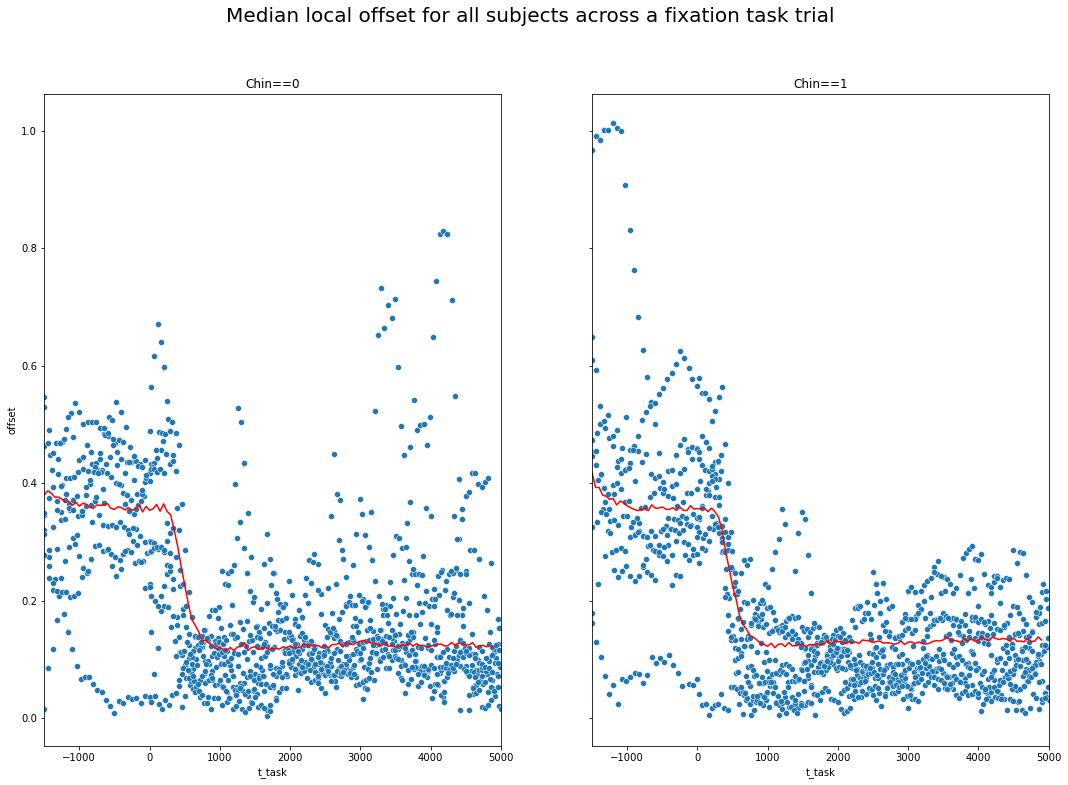

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [26]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')
data_trial_fix['offset'].describe()

count    3743.000000
mean        0.166263
std         0.130122
min         0.020502
25%         0.084502
50%         0.129210
75%         0.204950
max         1.752300
Name: offset, dtype: float64

In [27]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')


## Change across trials

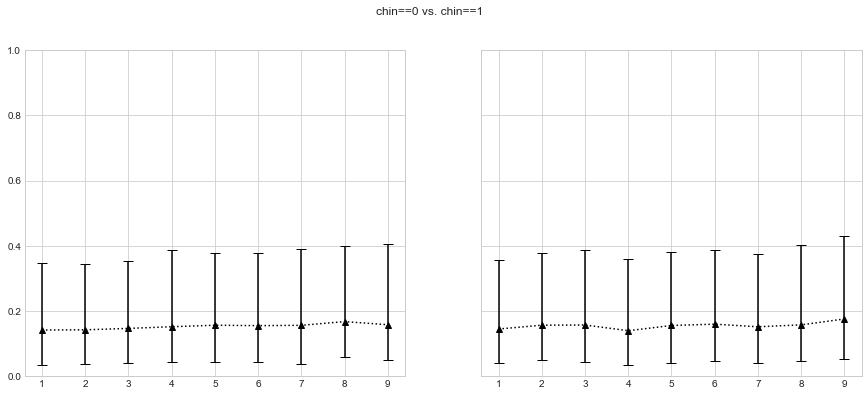

In [28]:
def group_chin_withinTaskIndex(data, varName):
    df_m = data.groupby(['chin', 'withinTaskIndex']) \
        [varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_median'}) \
        .reset_index()

    data = data.merge(df_m, on=['chin', 'withinTaskIndex'], how='left')
    data['above_median'] = data[varName] > data[varName + '_median']
    
    df_std_upper = data.loc[data['above_median']==1, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_upper'}) \
        .reset_index()
    df_std_lower = data.loc[data['above_median']==0, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_lower'}) \
        .reset_index()

    output = pd.concat([
        df_m, 
        df_std_upper[varName + '_std_upper'],
        df_std_lower[varName + '_std_lower']
    ], axis=1)
    return output


data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'offset'
)

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['offset_median'],
        yerr=[data['offset_std_lower'], data['offset_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Comparing across positions

### All positions

In [29]:
def outcome_by_position_long(outcome_var):
    output_long = data_trial_fix.groupby(['run_id', 'x_pos', 'y_pos'], as_index=False) \
    [outcome_var].median() 
    output_long['position'] = list(map(
        lambda x, y: str(x*100) + '%_' + str(y*100) + '%', 
        output_long['x_pos'], 
        output_long['y_pos']
    ))

    output_long['position_nr'] = output_long['position'] \
        .replace(
            [
                '20.0%_20.0%', '20.0%_50.0%', '20.0%_80.0%', 
                '50.0%_20.0%', '50.0%_50.0%', '50.0%_80.0%', 
                '80.0%_20.0%', '80.0%_50.0%', '80.0%_80.0%'
            ], 
            np.arange(1, 10)
        )
    return output_long

outcome_by_position_long('offset').head(5)

,run_id,x_pos,y_pos,offset,position,position_nr
0,4,0.2,0.2,0.265679,20.0%_20.0%,1
1,4,0.2,0.5,0.208599,20.0%_50.0%,2
2,4,0.2,0.8,0.228932,20.0%_80.0%,3
3,4,0.5,0.2,0.258921,50.0%_20.0%,4
4,4,0.5,0.5,0.207897,50.0%_50.0%,5


In [30]:
def outcome_by_position_wide(outcome_var):
    output_long = data_trial_fix.groupby(['run_id', 'x_pos', 'y_pos'], as_index=False) \
    [outcome_var].median() 
    output_long['position'] = list(map(
        lambda x, y: str(x*100) + '%_' + str(y*100) + '%', 
        output_long['x_pos'], 
        output_long['y_pos']
    ))

    output_long['position_nr'] = output_long['position'] \
        .replace(
            [
                '20.0%_20.0%', '20.0%_50.0%', '20.0%_80.0%', 
                '50.0%_20.0%', '50.0%_50.0%', '50.0%_80.0%', 
                '80.0%_20.0%', '80.0%_50.0%', '80.0%_80.0%'
            ], 
            np.arange(1, 10)
        )
    
    output_wide = pd.pivot_table(
        output_long, 
        index = 'run_id',
        columns = 'position',
        values = outcome_var).reset_index()

    null_data = output_wide.loc[output_wide.isnull().any(axis=1), :]
    if len(null_data)>0:
        print('! Attention ! Missing values')
        print(null_data)
    else:
        print('Success: No missing values found')

    return output_wide
    
outcome_by_position_wide('offset')

Success: No missing values found


position,run_id,20.0%_20.0%,20.0%_50.0%,20.0%_80.0%,50.0%_20.0%,50.0%_50.0%,50.0%_80.0%,80.0%_20.0%,80.0%_50.0%,80.0%_80.0%
0,4,0.265679,0.208599,0.228932,0.258921,0.207897,0.230479,0.428853,0.322680,0.250551
1,5,0.070783,0.087638,0.083162,0.074365,0.075722,0.066374,0.055398,0.057796,0.099017
2,6,0.130548,0.109199,0.132100,0.101676,0.151561,0.048144,0.158100,0.129393,0.088723
3,7,0.069552,0.076056,0.094204,0.114574,0.077544,0.069346,0.116827,0.061706,0.110298
4,11,0.260542,0.260419,0.617480,0.305825,0.175973,0.299290,0.269331,0.297330,0.398833
...,...,...,...,...,...,...,...,...,...,...
203,449,0.117523,0.112021,0.120988,0.093355,0.198585,0.057588,0.146894,0.113508,0.138622
204,454,0.096517,0.077071,0.136162,0.100810,0.181601,0.079179,0.094303,0.057751,0.126190
205,456,0.070752,0.084609,0.108904,0.145560,0.090945,0.084129,0.129111,0.083485,0.081061
206,458,0.451185,0.311148,0.417573,0.293742,0.072359,0.302359,0.413396,0.295295,0.399653


In [31]:
def pos_combinations():
    cols = [
                '20.0%_20.0%', '20.0%_50.0%', '20.0%_80.0%', 
                '50.0%_20.0%', '50.0%_50.0%', '50.0%_80.0%', 
                '80.0%_20.0%', '80.0%_50.0%', '80.0%_80.0%'
            ]
    combinations = np.array(np.meshgrid(cols, cols)).T.reshape((-1, 2))

    for i in range(0, len(combinations)):
        combinations[i] = np.sort(combinations[i], axis=None)

    combinations = pd.DataFrame(combinations, columns=['col1', 'col2'])
    combinations = combinations \
        .loc[combinations['col1']!=combinations['col2'], :] \
        .drop_duplicates() \
        .reset_index(drop=True)
    print(f"""N combinations: {len(combinations)}""")
    return combinations

combinations = pos_combinations()

N combinations: 36


Robert Rosenthal. The hand-book of research synthesis, chapter Parametric measures of effect size, pages 231–244. New York, NY: Russel Sage Foundation, 1994.
t / sqrt n

In [32]:
def test_all_positions(outcome_var):

    positions = outcome_by_position_wide(outcome_var)
    combinations = pos_combinations()    
    
    all_results = []

    n = len(positions['run_id'].unique())

    for i in combinations.index:
        result = stats.ttest_rel(
            positions[combinations.loc[i, 'col1']], 
            positions[combinations.loc[i, 'col2']])

        all_results.append([
            combinations.loc[i, 'col1'],
            combinations.loc[i, 'col2'],
            np.mean(positions[combinations.loc[i, 'col1']]),
            np.mean(positions[combinations.loc[i, 'col2']]),
            (result.statistic / np.sqrt(n)),
            result.statistic, 
            result.pvalue])

    position_tests = pd.DataFrame(
        all_results, 
        columns=[
            'position_1', 'position_2', 'position_1_mean', 'position_2_mean', 
            'd', 't', 'p'])

    # Holm correction
    position_tests['p'] = smt.multipletests(position_tests['p'], method='holm')[1]

    position_tests['Sig'] = 'np'
    position_tests.loc[position_tests['p']<0.05, 'Sig'] = """*"""
    position_tests.loc[position_tests['p']<0.01, 'Sig'] = """**"""
    position_tests.loc[position_tests['p']<0.001, 'Sig'] = """***"""

    return position_tests

position_tests = test_all_positions('offset')
position_tests.loc[
        position_tests['Sig']!='np'
    ].head(5)

Success: No missing values found
N combinations: 36


,position_1,position_2,position_1_mean,position_2_mean,d,t,p,Sig
0,20.0%_20.0%,20.0%_50.0%,0.180405,0.154442,0.358470,5.169924,1.156209e-05,***
3,20.0%_20.0%,50.0%_50.0%,0.180405,0.131245,0.516256,7.445548,7.668313e-11,***
4,20.0%_20.0%,50.0%_80.0%,0.180405,0.147619,0.360224,5.195230,1.074190e-05,***
6,20.0%_20.0%,80.0%_50.0%,0.180405,0.149456,0.351593,5.070746,1.668196e-05,***
8,20.0%_50.0%,20.0%_80.0%,0.154442,0.192389,-0.523023,-7.543150,4.413716e-11,***


### Top vs. Bottom

In [33]:
def test_top_vs_bottom_positions(outcome_var):
    offset_by_y_long = outcome_by_position_long(outcome_var) \
        .groupby(['run_id', 'y_pos'], as_index=False)[outcome_var].mean()
    offset_by_y_long = offset_by_y_long \
        .loc[offset_by_y_long['y_pos']!=0.5, :]
    
    offset_by_y_wide = pd.pivot_table(
        offset_by_y_long, 
        index = 'run_id',
        columns = 'y_pos',
        values = outcome_var).reset_index()
    
    offset_by_y_wide.columns=['run_id', '20%', '80%']
    result = stats.ttest_rel(
            offset_by_y_wide['20%'], 
            offset_by_y_wide['80%']
    )

    n = len(offset_by_y_wide['run_id'].unique())
    print(f"""d: {(result.statistic / np.sqrt(n))}""")

    return result

test_top_vs_bottom_positions('offset')

d: 0.10861358880176587


Ttest_relResult(statistic=1.5664474545477127, pvalue=0.11877131375122889)

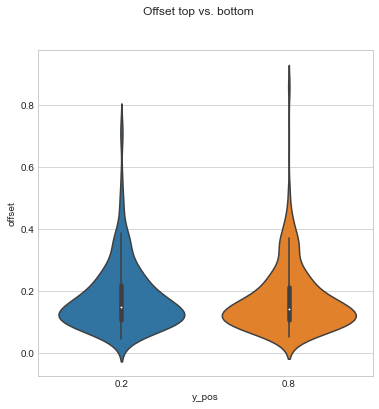

In [34]:
offset_by_y_long = outcome_by_position_long('offset') \
    .groupby(['run_id', 'y_pos'], as_index=False)['offset'].mean()
offset_by_y_long = offset_by_y_long \
    .loc[offset_by_y_long['y_pos']!=0.5, :]
offset_by_y_long

fig, axes = plt.subplots(1, 1, sharey=True, figsize=(6,6))
fig.suptitle('Offset top vs. bottom ')

sns.violinplot(ax=axes, 
               x='y_pos', 
               y='offset', 
               data=offset_by_y_long)   
plt.show()

### Left vs. right

In [35]:
def test_left_vs_right_positions(outcome_var):
    offset_by_x_long = outcome_by_position_long(outcome_var) \
        .groupby(['run_id', 'x_pos'], as_index=False)[outcome_var].mean()
    offset_by_x_long = offset_by_x_long \
        .loc[offset_by_x_long['x_pos']!=0.5, :]
    
    offset_by_x_wide = pd.pivot_table(
        offset_by_x_long, 
        index = 'run_id',
        columns = 'x_pos',
        values = outcome_var).reset_index()
    
    offset_by_x_wide.columns=['run_id', '20%', '80%']
    result = stats.ttest_rel(
            offset_by_x_wide['20%'], 
            offset_by_x_wide['80%']
    )
    
    n = len(offset_by_x_wide['run_id'].unique())
    print(f"""d: {(result.statistic / np.sqrt(n))}""")

    return result

test_left_vs_right_positions('offset')

d: 0.07438344448528453


Ttest_relResult(statistic=1.0727732925492899, pvalue=0.2846218872219799)

## Aggregate on subject-level 

In [36]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [37]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,208.000000,208.000000,208.000000,123.000000,85.000000
mean,0.166240,0.163186,0.169300,0.162335,0.171892
std,0.091354,0.108460,0.103352,0.100183,0.077034
min,0.053580,0.045764,0.053778,0.053580,0.063450
25%,0.107420,0.102927,0.103391,0.100714,0.114808
50%,0.142499,0.132334,0.139972,0.137596,0.158881
75%,0.192994,0.192013,0.196629,0.178942,0.211358
max,0.696792,1.018857,0.731460,0.696792,0.456543


In [38]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,208.000000,208.000000,208.000000,123.000000,85.000000
mean,196.668020,190.845265,202.495057,191.855443,203.632102
std,128.863826,137.563536,156.235623,137.756844,115.225426
min,63.404467,53.524854,58.066425,63.404467,63.620122
25%,122.313095,116.591999,115.234164,112.866546,128.443699
50%,163.348670,151.846294,162.181535,145.932391,186.133715
75%,229.290219,221.058914,238.991859,204.388887,238.169404
max,1073.632845,1111.197358,1424.506794,1073.632845,851.448521


## Grand mean offset

In [39]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-39-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,3743.000000,3743.000000,3743.000000,3743.000000
mean,0.516244,797.279915,0.515377,459.743402
std,0.224893,387.279585,0.212192,211.457216
min,-0.163394,-313.716982,-0.299543,-323.505966
25%,0.315877,495.025353,0.349307,305.482703
50%,0.514125,756.257231,0.521250,449.157177
75%,0.718881,1057.112576,0.678710,591.000000
max,1.679502,3439.619490,2.171791,2280.380605


In [40]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    3743.000000
mean        0.152265
std         0.133288
min         0.000995
25%         0.067660
50%         0.116198
75%         0.195543
max         1.751256
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [41]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-41-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,2.149320e+05,2.149320e+05
mean,7.145013e-03,1.071460e+04
std,2.613690e-02,3.396292e+04
min,6.162976e-33,3.231174e-27
25%,8.204835e-04,1.120252e+03
50%,2.415132e-03,3.435563e+03
75%,6.283492e-03,9.409318e+03
max,3.006582e+00,3.025471e+06


## Aggregate standard deviation on trial-level

In [42]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    3.743000e+03
mean     7.100026e-02
std      4.384871e-02
min      7.850462e-17
25%      4.676635e-02
50%      6.188314e-02
75%      8.454794e-02
max      7.142820e-01
Name: precision, dtype: float64


In pixel

In [43]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    3.743000e+03
mean     8.665207e+01
std      5.428610e+01
min      5.684342e-14
25%      5.452335e+01
50%      7.443942e+01
75%      1.043338e+02
max      8.761510e+02
Name: precision_px, dtype: float64


Any missing values?

In [44]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision


## Precision across trials

In [45]:
data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'precision'
)
data_plot

,index,chin,withinTaskIndex,precision_median,precision_std_upper,precision_std_lower
0,0,0.0,1.0,0.110282,0.135175,0.085738
1,1,0.0,2.0,0.103023,0.139728,0.083994
2,2,0.0,3.0,0.109256,0.135340,0.087354
3,3,0.0,4.0,0.110453,0.132297,0.088133
4,4,0.0,5.0,0.107408,0.129632,0.084568
5,5,0.0,6.0,0.105884,0.130610,0.083563
6,6,0.0,7.0,0.109592,0.138989,0.082752
7,7,0.0,8.0,0.107756,0.128931,0.083380
8,8,0.0,9.0,0.108064,0.135136,0.084843
9,9,1.0,1.0,0.113283,0.140076,0.083914


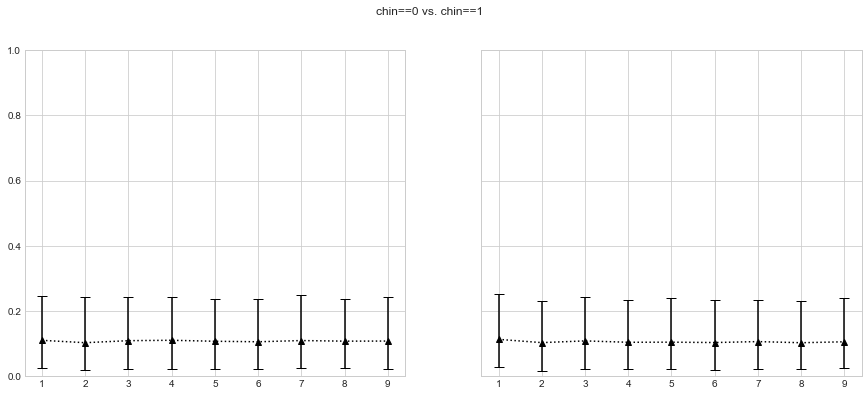

In [46]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['precision_median'],
        yerr=[data['precision_std_lower'], data['precision_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Comparing across positions

### All positions

In [47]:
outcome_by_position_long('precision').head(5)

,run_id,x_pos,y_pos,precision,position,position_nr
0,4,0.2,0.2,0.124112,20.0%_20.0%,1
1,4,0.2,0.5,0.071542,20.0%_50.0%,2
2,4,0.2,0.8,0.109671,20.0%_80.0%,3
3,4,0.5,0.2,0.067478,50.0%_20.0%,4
4,4,0.5,0.5,0.050869,50.0%_50.0%,5


In [48]:
outcome_by_position_wide('precision')

Success: No missing values found


position,run_id,20.0%_20.0%,20.0%_50.0%,20.0%_80.0%,50.0%_20.0%,50.0%_50.0%,50.0%_80.0%,80.0%_20.0%,80.0%_50.0%,80.0%_80.0%
0,4,0.124112,0.071542,0.109671,0.067478,0.050869,0.075636,0.182862,0.061657,0.084625
1,5,0.073310,0.056162,0.031550,0.059918,0.049777,0.033818,0.048662,0.047685,0.043979
2,6,0.063568,0.048119,0.083652,0.052744,0.039908,0.041933,0.080441,0.055996,0.073083
3,7,0.046485,0.068752,0.068729,0.105957,0.047884,0.044864,0.083768,0.056815,0.061422
4,11,0.147569,0.164793,0.319442,0.166676,0.140086,0.129554,0.126989,0.124975,0.260824
...,...,...,...,...,...,...,...,...,...,...
203,449,0.125545,0.051804,0.045367,0.083500,0.064218,0.046992,0.071074,0.046893,0.035794
204,454,0.042047,0.063085,0.046671,0.039146,0.042027,0.041412,0.065121,0.051105,0.062837
205,456,0.071405,0.080865,0.079777,0.040830,0.050639,0.071839,0.091301,0.065207,0.060427
206,458,0.056729,0.052940,0.049901,0.053502,0.070436,0.052775,0.060394,0.052997,0.061208


In [49]:
position_tests = test_all_positions('precision')
position_tests.loc[
        position_tests['Sig']!='np'
    ].head(5)

Success: No missing values found
N combinations: 36


,position_1,position_2,position_1_mean,position_2_mean,d,t,p,Sig
0,20.0%_20.0%,20.0%_50.0%,0.079829,0.069811,0.331340,4.778656,9.021940e-05,***
1,20.0%_20.0%,20.0%_80.0%,0.079829,0.070322,0.259619,3.744283,5.392033e-03,**
3,20.0%_20.0%,50.0%_50.0%,0.079829,0.063471,0.547355,7.894060,5.880925e-12,***
4,20.0%_20.0%,50.0%_80.0%,0.079829,0.063703,0.558272,8.051514,2.281742e-12,***
6,20.0%_20.0%,80.0%_50.0%,0.079829,0.068966,0.360352,5.197064,1.452087e-05,***


### Top vs. Bottom

In [50]:
test_top_vs_bottom_positions('precision')

d: 0.5670964912837084


Ttest_relResult(statistic=8.17878190983651, pvalue=2.8622799978885674e-14)

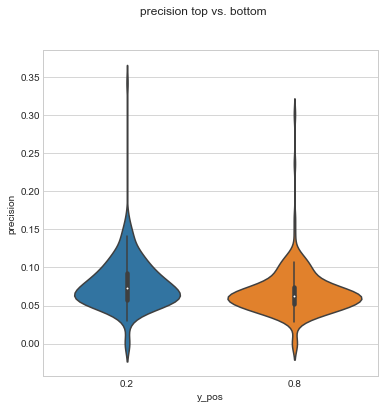

In [51]:
precision_by_y_long = outcome_by_position_long('precision') \
    .groupby(['run_id', 'y_pos'], as_index=False)['precision'].mean()
precision_by_y_long = precision_by_y_long \
    .loc[precision_by_y_long['y_pos']!=0.5, :]

fig, axes = plt.subplots(1, 1, sharey=True, figsize=(6,6))
fig.suptitle('precision top vs. bottom ')

sns.violinplot(ax=axes, 
               x='y_pos', 
               y='precision', 
               data=precision_by_y_long)   
plt.show()

### Left vs. right

In [52]:
test_left_vs_right_positions('precision')

d: 0.0502101090478121


Ttest_relResult(statistic=0.7241404908740996, pvalue=0.46979710356748916)

## Aggregate on subject-level 

In [53]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,208.000000,208.000000,208.000000,123.000000,85.000000
mean,0.070995,0.071982,0.070012,0.069872,0.072621
std,0.028156,0.028971,0.036141,0.031212,0.023112
min,0.000002,0.000001,0.000003,0.000002,0.000002
25%,0.055581,0.056701,0.053052,0.054539,0.061438
50%,0.066118,0.068226,0.062417,0.064200,0.069094
75%,0.080382,0.081154,0.079039,0.079854,0.080430
max,0.270525,0.284938,0.408137,0.270525,0.175656


In pixel

In [54]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,208.000000,208.000000,208.000000,123.000000,85.000000
mean,86.651847,87.671664,85.636334,86.639860,86.669191
std,36.965365,40.613419,42.306786,40.727766,30.954085
min,0.002047,0.001429,0.002666,0.002047,0.002948
25%,63.201198,64.100012,60.567183,60.300349,68.476770
50%,79.105508,80.972582,77.596037,80.131849,78.902940
75%,103.594767,102.850533,100.062424,104.404935,100.041673
max,256.587017,362.502875,391.176827,256.587017,193.716322


# chinFirst: Randomization worked? 

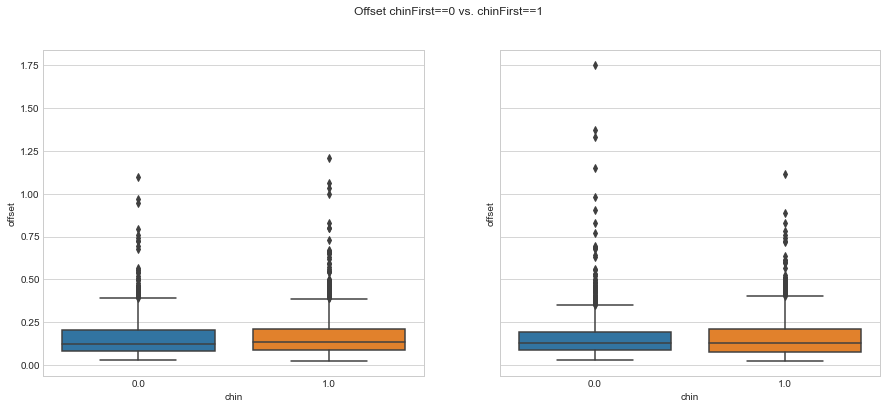

In [55]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

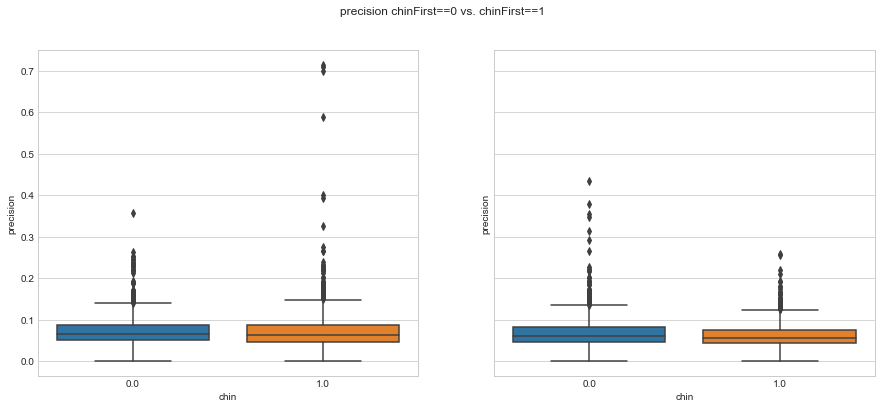

In [56]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

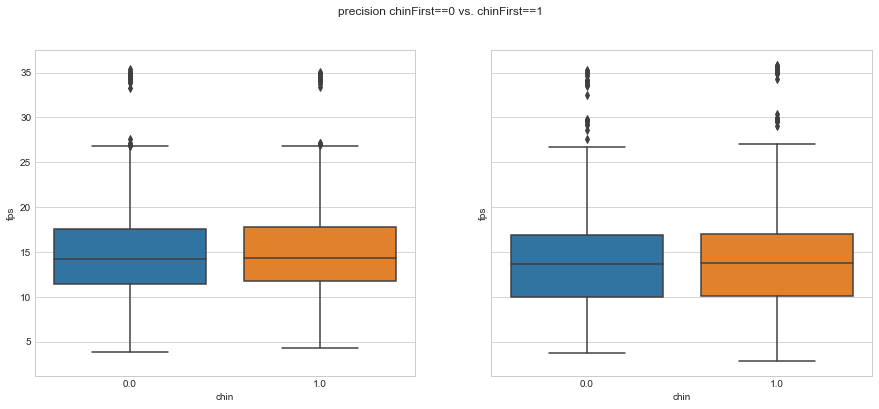

In [57]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Main effects 

## Chin-rest
 - t-tests will follow
 - TODO: Compare subjects with high fps (Semmelmann & Weigelt, 2019)

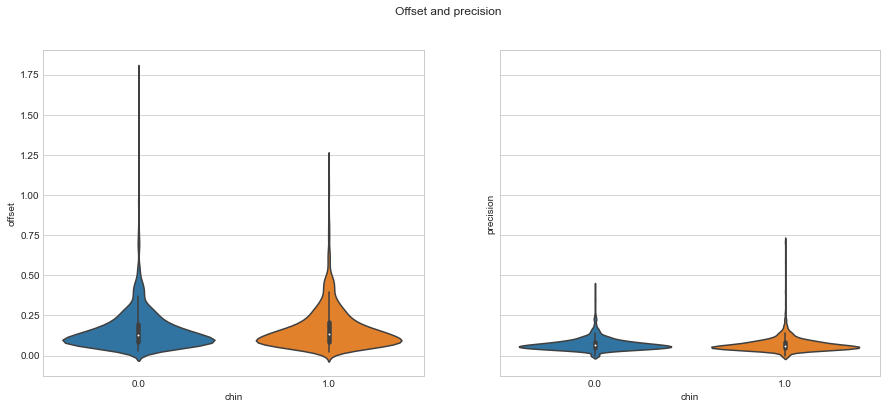

In [58]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               data=data_trial_fix)
   
plt.show()

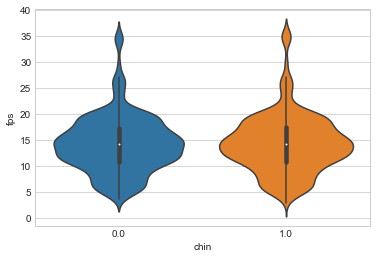

In [59]:
sns.violinplot(x='chin', y='fps', data=data_trial_fix)   
plt.show()

In [61]:
offset_and_precision_by_chin = data_trial \
    .groupby(['run_id', 'chin'], as_index=False)['offset', 'precision'].mean() \
    .pivot(index='run_id', columns='chin', values=['offset', 'precision'])
offset_and_precision_by_chin.head(5)

<ipython-input-61-6898aa76d60b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  offset_and_precision_by_chin = data_trial \


offset           precision          
chin         0.0       1.0       0.0       1.0
run_id                                        
4       0.268464  0.148017  0.158217  0.124455
5       0.123552  0.196288  0.139792  0.155056
6       0.135441  0.207695  0.138479  0.159867
7       0.097041  0.098426  0.116133  0.175224
11      0.183716  0.242762  0.159709  0.176506

In [62]:
summary = offset_and_precision_by_chin.mean() \
    .reset_index() \
    .rename(columns={'level_0': 'measure', 0: 'mean'}) \
    .assign(Var=offset_and_precision_by_chin.var().reset_index(drop=True))

In [63]:
result_offset = scipy.stats.ttest_rel(
    offset_and_precision_by_chin.loc[:, [('offset', 0.0)]],
    offset_and_precision_by_chin.loc[:, [('offset', 1.0)]]
)

result_precision = scipy.stats.ttest_rel(
    offset_and_precision_by_chin.loc[:, [('precision', 0.0)]],
    offset_and_precision_by_chin.loc[:, [('precision', 1.0)]]
)

chin_test = pd.DataFrame({
    'measure': ['offset', 'precision'],
    't': [result_offset.statistic, result_precision.statistic],
    'p': [result_offset.pvalue, result_precision.pvalue]
    }
)
chin_test['t'] = (chin_test['t']).astype(float)
chin_test['p'] = (chin_test['p']).astype(float)

chin_test

summary.merge(
    chin_test, 
    on='measure',
    how='left'
)

,measure,chin,mean,Var,t,p
0,offset,0.0,0.164184,0.005037,-4.766419,0.000004
1,offset,1.0,0.187119,0.004803,-4.766419,0.000004
2,precision,0.0,0.132824,0.002446,-1.551017,0.122425
3,precision,1.0,0.138626,0.001392,-1.551017,0.122425


## Visual Aid

### Frequency of visual aids

In [64]:
for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight        21
noCorrection     95
progressive      17
shortSight       76


col_0          count
sight               
contactLenses     25
glasses           85
notCorrected       8
perfectSight      91


col_0           count
glasses_binary       
0.0               124
1.0                85




### Plots

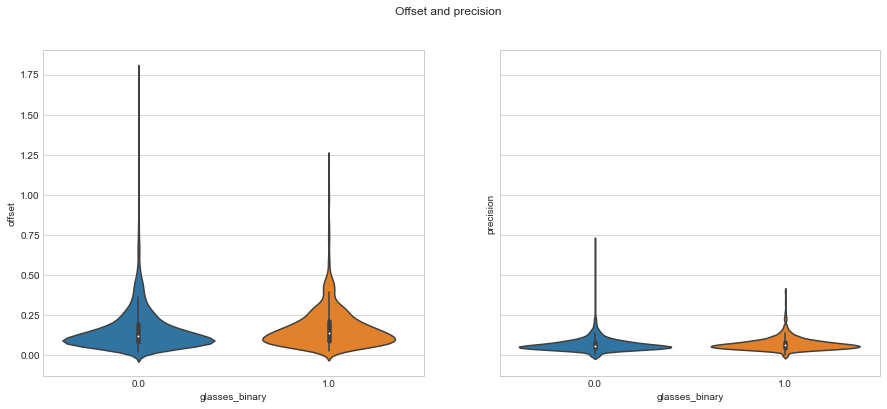

In [65]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='glasses_binary', 
               y='offset', 
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='glasses_binary', 
               y='precision', 
               data=data_trial_fix)
   
plt.show()

### Sight

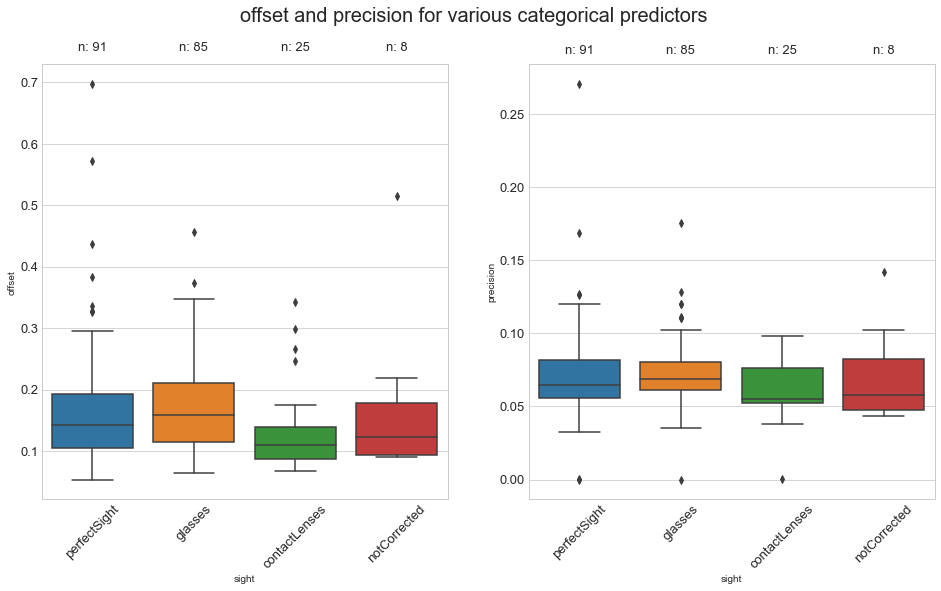

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
fig.suptitle('offset and precision for various categorical predictors', fontsize=20)
plt.subplots_adjust(hspace=0.5)

outcomes = ['offset', 'precision']
ax = ax.ravel()

for i in range(0, 2):
    sns.boxplot(ax=ax[i], x='sight', y=outcomes[i], data=data_subject)

    ax[i].tick_params(labelrotation=45, labelsize=13)
    ax[i].tick_params(axis='y', labelrotation=None)
    
    nobs = data_subject['sight'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))
    
    max_value = data_subject[outcomes[i]].max()
    yPos = max_value + max_value * 0.1
    
    for tick,label in zip(pos,ax[i].get_xticklabels()):                
        ax[i].text(
            pos[tick], yPos, nobs[tick],
            verticalalignment='top',
            horizontalalignment='center', size=13, weight='normal')

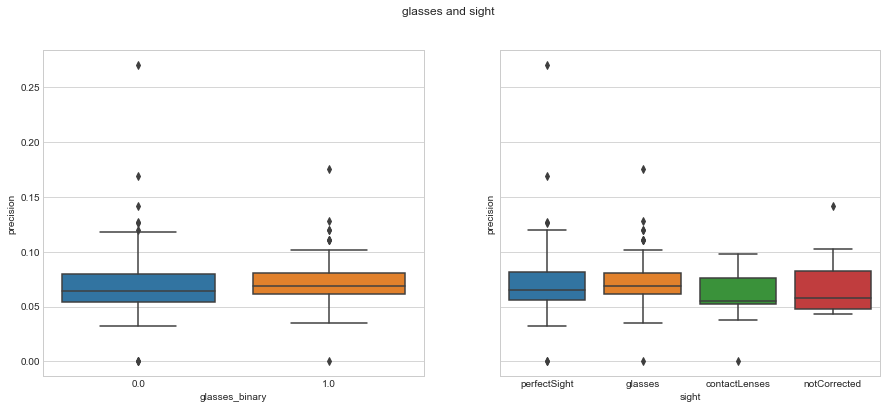

In [67]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='precision', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='precision', data=data_subject)
   
plt.show()

In [68]:
sight_lm = ols('offset ~ sight', data=data_subject).fit()
offset_table = sm.stats.anova_lm(sight_lm, typ=2) # Type 2 ANOVA DataFrame

sight_lm = ols('precision ~ sight', data=data_subject).fit()
precision_table = sm.stats.anova_lm(sight_lm, typ=2) # Type 2 ANOVA DataFrame

print(
    f"""Offset table: \n """
    f"""{offset_table} \n \n"""
    f"""Precision table: \n"""
    f"""{precision_table}"""
)

Offset table: 
             sum_sq     df         F    PR(>F)
sight     0.025595    3.0  1.022631  0.383602
Residual  1.701938  204.0       NaN       NaN 
 
Precision table: 
            sum_sq     df         F    PR(>F)
sight     0.002213    3.0  0.929536  0.427385
Residual  0.161890  204.0       NaN       NaN


### ttest

In [69]:
offset_and_precision_by_glasses = data_subject \
    .pivot(index='run_id', columns='glasses_binary', values=['offset', 'precision'])

In [70]:
summary = offset_and_precision_by_glasses.mean() \
    .reset_index() \
    .rename(columns={'level_0': 'measure', 0: 'mean'}) \
    .assign(n = offset_and_precision_by_glasses.count().reset_index(drop=True)) \
    .assign(Var=offset_and_precision_by_glasses.var().reset_index(drop=True))

In [71]:
result_offset = scipy.stats.ttest_ind(
    offset_and_precision_by_glasses.loc[:, [('offset', 0.0)]].dropna(),
    offset_and_precision_by_glasses.loc[:, [('offset', 1.0)]].dropna(),
    equal_var = False
)

result_precision = scipy.stats.ttest_ind(
    offset_and_precision_by_glasses.loc[:, [('precision', 0.0)]].dropna(),
    offset_and_precision_by_glasses.loc[:, [('precision', 1.0)]].dropna(),
    equal_var = False
)

glasses_test = pd.DataFrame({
    'measure': ['offset', 'precision'],
    't': [result_offset.statistic, result_precision.statistic],
    'p': [result_offset.pvalue, result_precision.pvalue]
    }
)
glasses_test['t'] = (glasses_test['t']).astype(float)
glasses_test['p'] = (glasses_test['p']).astype(float)

summary.merge(
    glasses_test, 
    on='measure',
    how='left'
)

,measure,glasses_binary,mean,n,Var,t,p
0,offset,0.0,0.162335,123,0.010037,-0.776701,0.438237
1,offset,1.0,0.171892,85,0.005934,-0.776701,0.438237
2,precision,0.0,0.069872,123,0.000974,-0.729293,0.466655
3,precision,1.0,0.072621,85,0.000534,-0.729293,0.466655


# Visual aid & chin rest

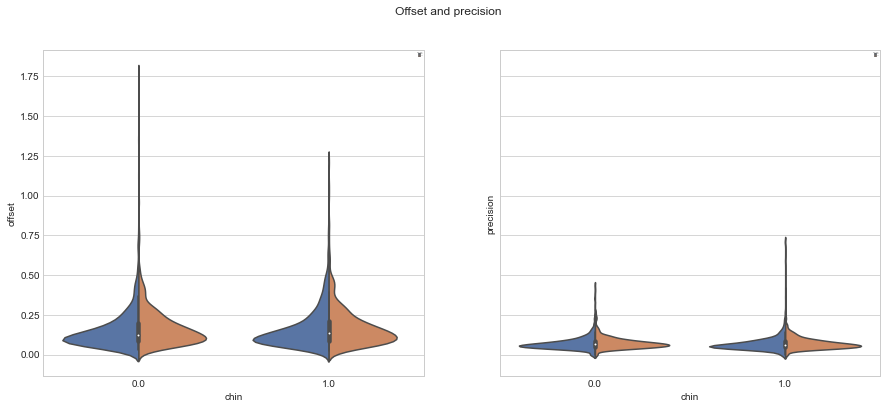

In [72]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.set(font_scale=0)
sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               hue='glasses_binary',
               split=True,
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               hue='glasses_binary',
               split=True,
               data=data_trial_fix)
   
plt.show()

# Gaze predictions

## Gaze dot positions for each position

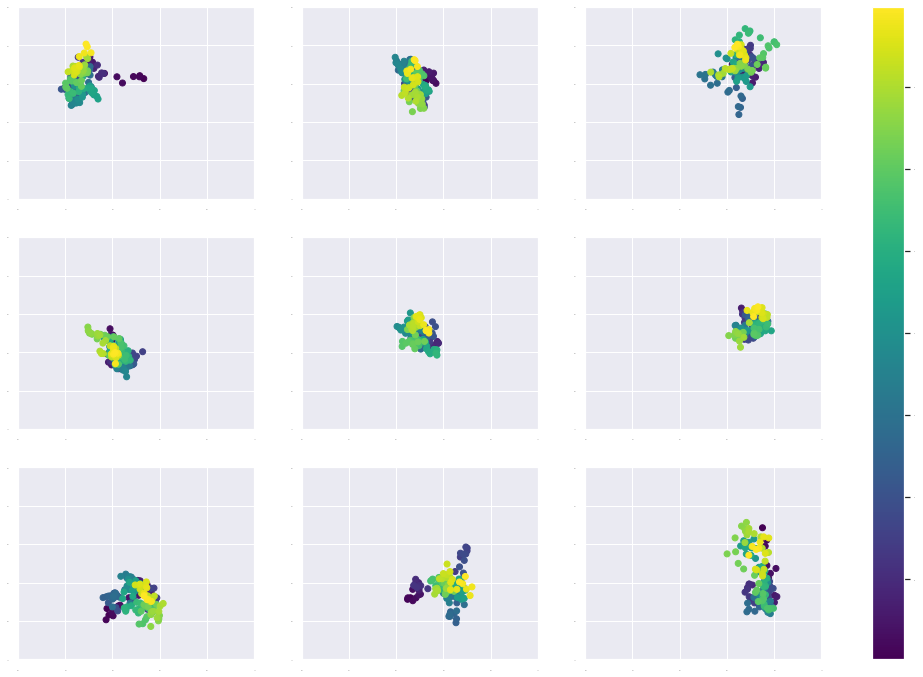

In [73]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

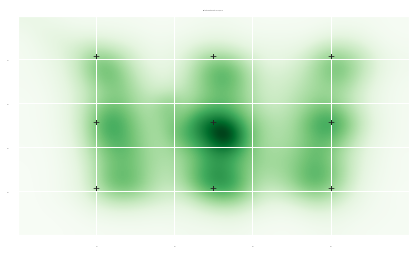

<Figure size 432x288 with 0 Axes>

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Additional analyis

## Median offset across calibration trials
Does data quality improve during calibration? 

In [75]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial \
    .loc[data_trial['trial_type']=='eyetracking-calibration', :]

# Add median offset 
grouped = data_et_calibration \
    .groupby(['run_id', 'trial_index'])['offset'].median() \
    .reset_index() \
    .rename(columns={'offset': 'offset_median'}) 
data_trial_calibration = data_trial_calibration.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
)

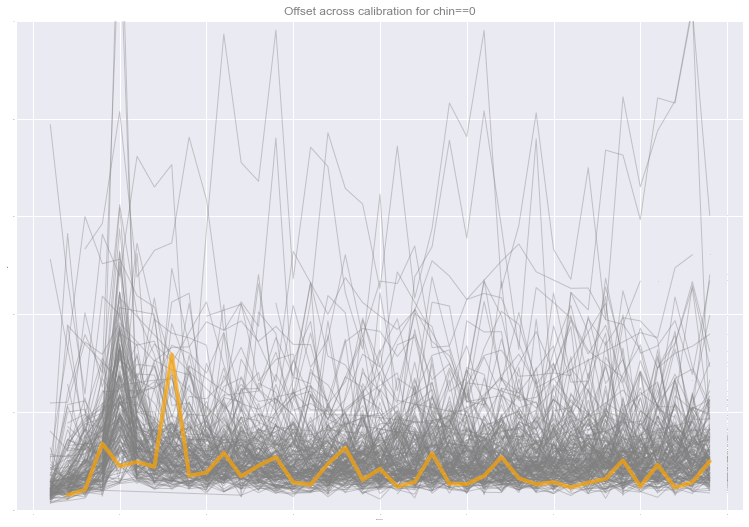

In [76]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

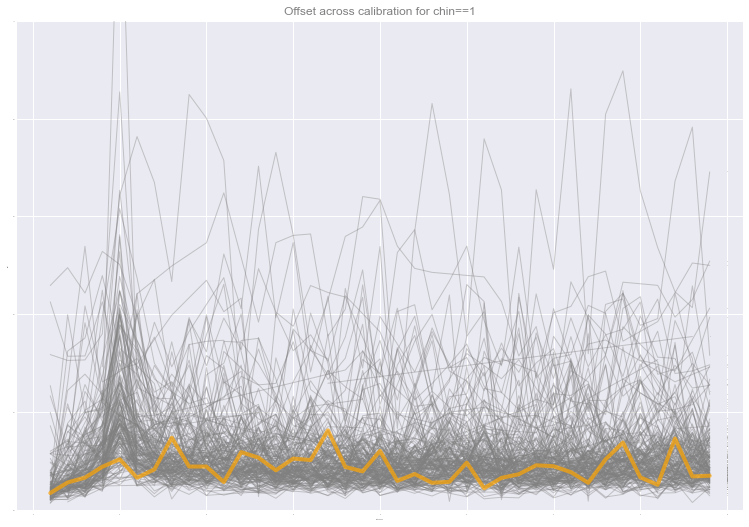

In [77]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Median precision across calibration trials

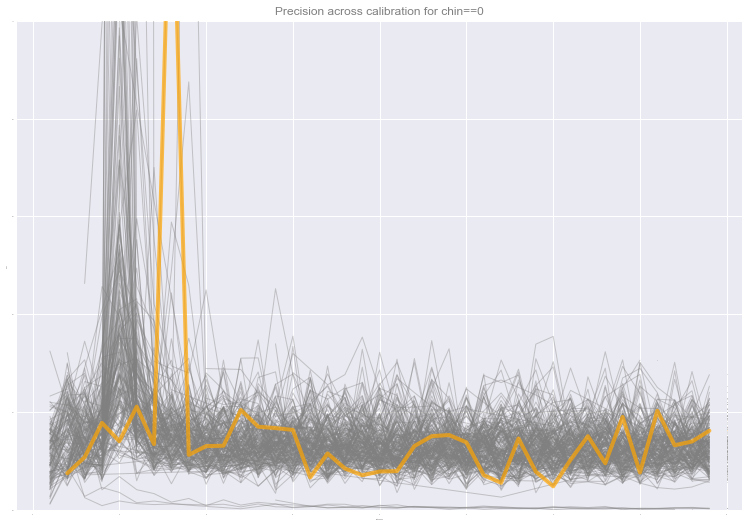

In [78]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

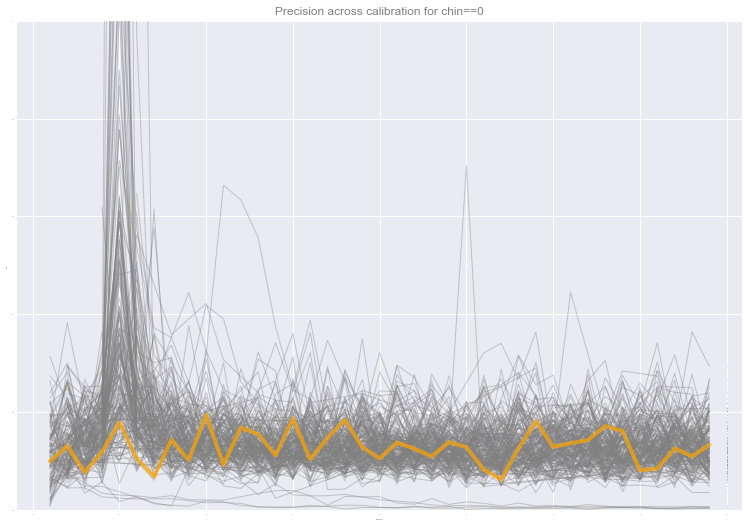

In [79]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## Categorical confounders

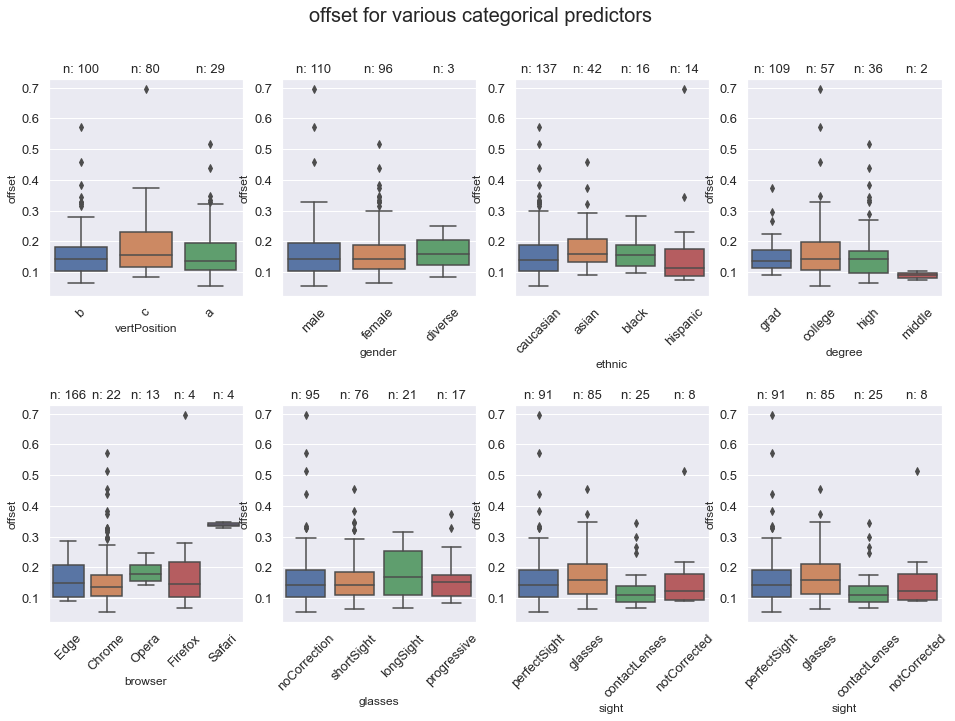

In [90]:
def getBoxPlots(outcome, yPos):
    predictors = [
    'vertPosition', 'gender', 'ethnic',  
    'degree', 'browser', 'glasses', 'sight', 'sight']  

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
    fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
        
    
    ax = ax.ravel()
    
    for i in range(0, 8):
        sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)
        
        ax[i].tick_params(labelrotation=45, labelsize=13)
        ax[i].tick_params(axis='y', labelrotation=None)
        
        nobs = data_subject[predictors[i]].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        
        for tick,label in zip(pos,ax[i].get_xticklabels()):                
            ax[i].text(
                pos[tick], yPos, nobs[tick],
                verticalalignment='top',
                horizontalalignment='center', size=13, weight='normal')
            
getBoxPlots('offset', 0.78)

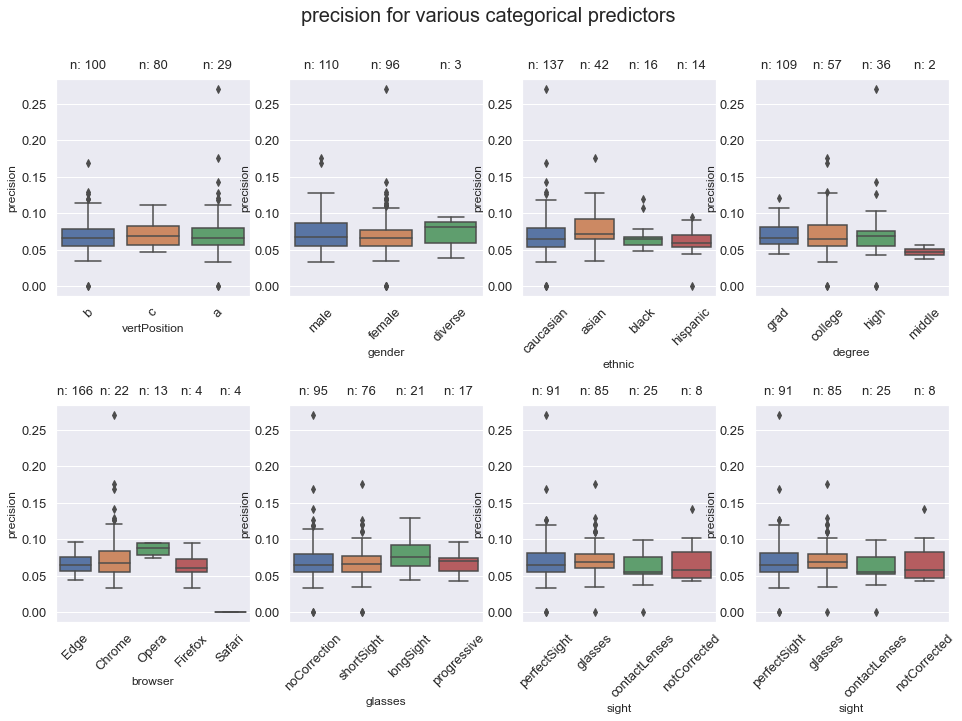

In [91]:
getBoxPlots('precision', yPos=0.31)

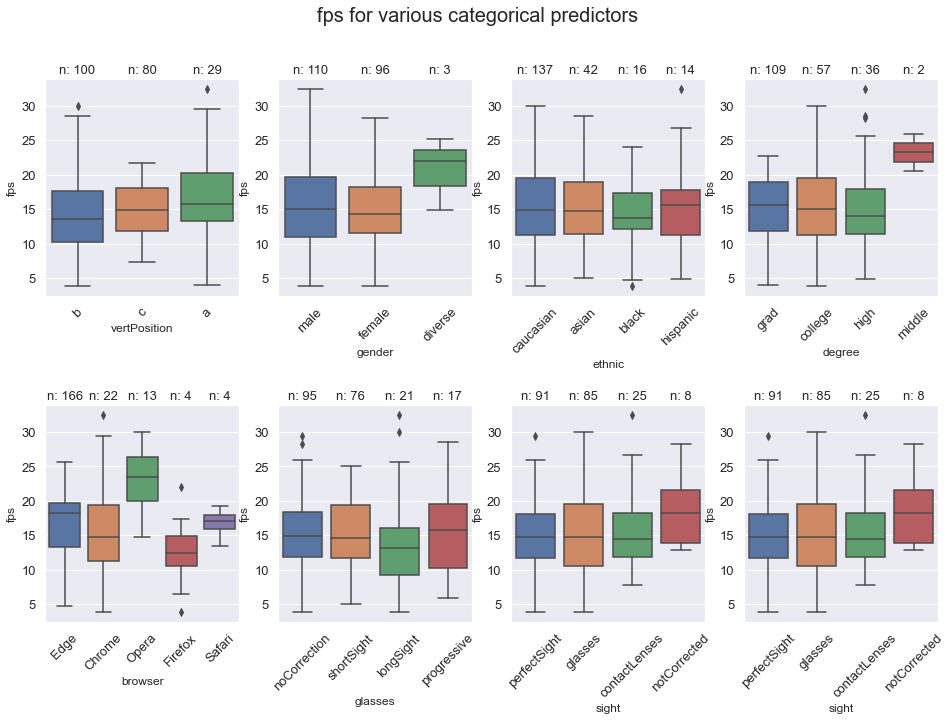

In [92]:
getBoxPlots('fps', yPos=36)

## Correlation Plot

### Clean dataset

In [93]:
data_plot = data_trial_fix \
    .merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left') \
    .loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]

if len(null_data)>0:
    print('! Attention ! Missing values')
    print(
        f"""Length of data raw: {len(data_plot)} \n"""
        f"""Excluded runs and trials: \n"""
        f"""{null_data.groupby(['run_id'], as_index=False)['chin'].count().rename(columns={'chin': 'n'})} \n"""
    )
else: 
    print('No missing data found')

data_plot = data_plot.loc[~data_plot.isnull().any(axis=1), :]

print(
        f"""Length of data clean: {len(data_plot)} \n""" 
)

! Attention ! Missing values
Length of data raw: 3743 
Excluded runs and trials: 
   run_id   n
0     436  18 

Length of data clean: 3725 



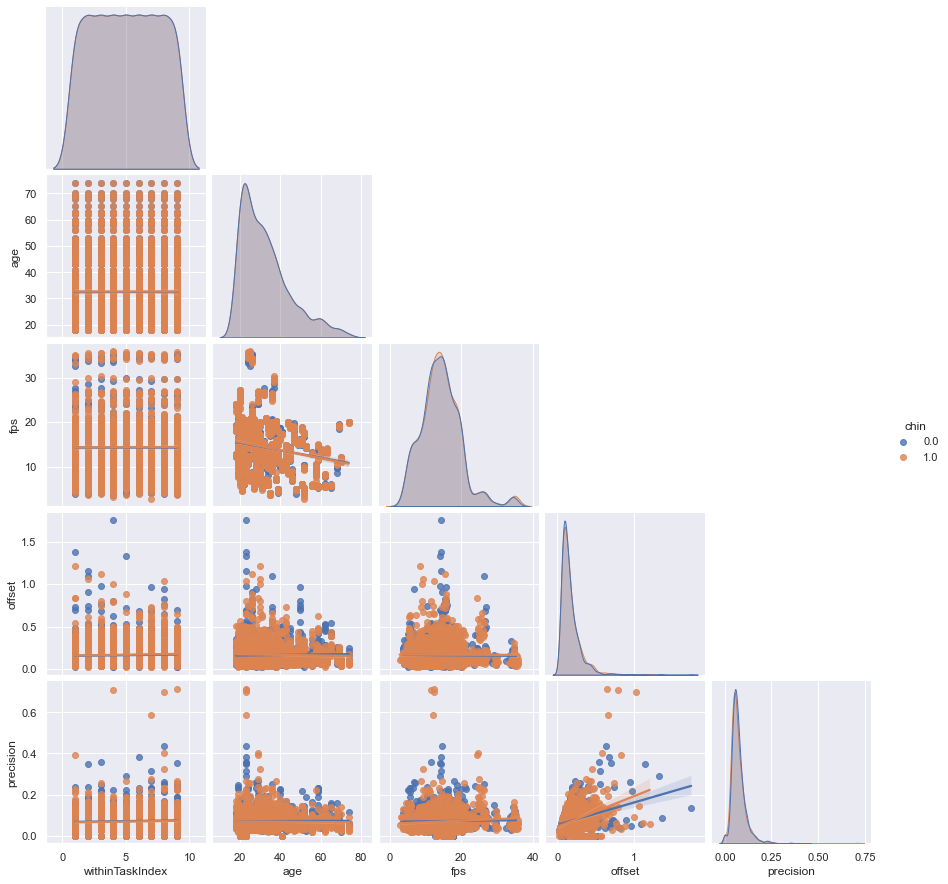

In [84]:
correlation_columns = ['withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.set()
sns.pairplot(
    data_plot.loc[:, np.append(correlation_columns, ['chin'])], 
    hue='chin', hue_order = [0.0, 1.0],
    kind='reg', 
    corner=True
)

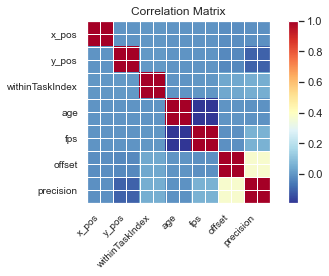

In [85]:
corr_columns = np.append(['x_pos', 'y_pos'], correlation_columns)
corr_matrix = np.corrcoef(data_plot[corr_columns].T)

smg.plot_corr(corr_matrix, xnames=corr_columns)
plt.show()

In [86]:
data_plot[corr_columns].rcorr()

,x_pos,y_pos,withinTaskIndex,age,fps,offset,precision
x_pos,-,,,,,,
y_pos,0.0,-,,,,,***
withinTaskIndex,0.005,0.009,-,,,*,***
age,-0.0,0.0,-0.0,-,***,,
fps,-0.0,0.0,0.003,-0.189,-,,***
offset,-0.016,-0.022,0.041,-0.002,-0.01,-,***
precision,-0.008,-0.103,0.055,-0.006,0.062,0.376,-


In [87]:
data_plot[corr_columns].rcorr(upper='n')

,x_pos,y_pos,withinTaskIndex,age,fps,offset,precision
x_pos,-,3725,3725,3725,3725,3725,3725
y_pos,0.0,-,3725,3725,3725,3725,3725
withinTaskIndex,0.005,0.009,-,3725,3725,3725,3725
age,-0.0,0.0,-0.0,-,3725,3725,3725
fps,-0.0,0.0,0.003,-0.189,-,3725,3725
offset,-0.016,-0.022,0.041,-0.002,-0.01,-,3725
precision,-0.008,-0.103,0.055,-0.006,0.062,0.376,-


# Export

In [88]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [89]:
print('Success! Script ran through')

Success! Script ran through
